In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score



/Users/davidhoffman/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
DIS = "/Users/davidhoffman/desktop/stocks_download/DIS_2006-01-01_to_2018-01-01.csv"
df = pd.read_csv(DIS, index_col="Date", parse_dates=True)

In [3]:
#Only keep closing price of the day
df.drop(['Open','High','Low'], axis = 1, inplace = True)
df.drop(['Name'], axis = 1, inplace = True)
df.drop(['Volume'], axis = 1, inplace = True)

In [4]:
#Perform Dicky Fuller test to test for stationarity
# Function taken from class lecture


def test_stationarity(timeseries):

    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    # Plotting rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Performing a Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    print(dfoutput )

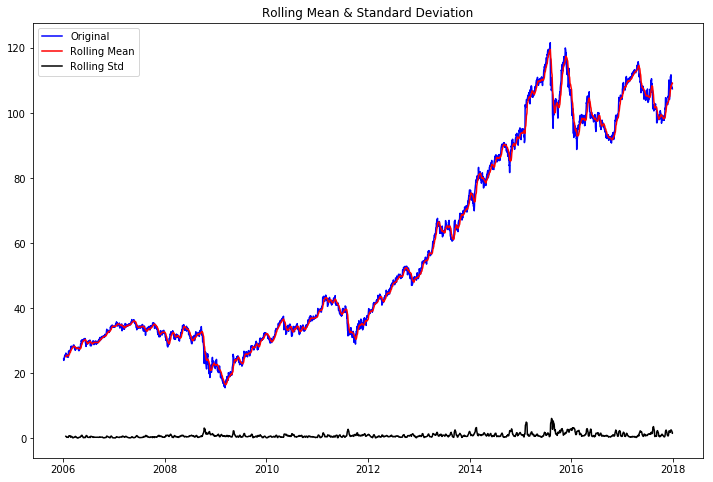

Results of Dickey-Fuller Test:
Test Statistic   -0.263906
p-value           0.930463
dtype: float64


In [5]:
#testing stationarity

test_stationarity(df.Close)

In [16]:
#High pvalue --> no stationarity
#Must get to a point of stationarity for the time series
#Will get the difference in my values
df['close_diff_1']=df.Close.diff()
df['close_diff_2']=df.close_diff_1.diff()

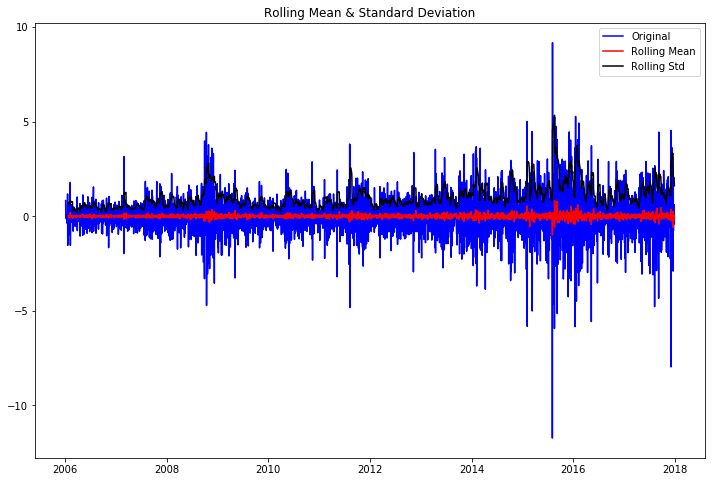

Results of Dickey-Fuller Test:
Test Statistic   -1.729950e+01
p-value           5.640082e-30
dtype: float64


In [18]:
#Testing for stationarity with my sceond differenced values 

test_stationarity(df.close_diff_2.dropna())

In [8]:
#Seperate into train and test

train = df.Close[:-31]
test = df.Close[len(train-1):]

In [9]:
#Difference the train set
train_diff = train.diff()

In [10]:
#fit model
ar1ma1 = ARIMA(train.dropna().values, (1,2,1)).fit(disp=0)


/Users/davidhoffman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/davidhoffman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


In [11]:
#predict out of sample month ---> test set

preds = ar1ma1.predict(start=len(train)-50,end=len(train)+10)

/Users/davidhoffman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [12]:
##### predict out of sample month ---> test set

#ar1ma1.plot_predict(2950,3020,dynamic=True)

/Users/davidhoffman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


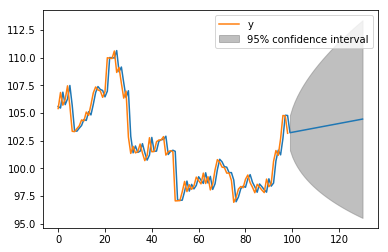

In [13]:
##### predict out of sample month ---> test set

ar1ma1.plot_predict(2890,3020,dynamic=False)

In [14]:
#Add predictions to the last value in train set
full_pred = train[len(train)-50]+np.cumsum(preds)

In [15]:
for i in range(79):
    print ("actual", test[i], "predicted", full_pred[i])
    print ("difference (pred - actual)", full_pred[i]-test[i])

actual 103.69 predicted 101.43830213339392
difference (pred - actual) -2.2516978666060794
actual 103.6 predicted 101.57818516208218
difference (pred - actual) -2.021814837917816
actual 103.44 predicted 106.09169294140132
difference (pred - actual) 2.651692941401322
actual 102.75 predicted 106.11915635614668
difference (pred - actual) 3.369156356146675
actual 103.0 predicted 106.13654145240335
difference (pred - actual) 3.1365414524033497
actual 102.74 predicted 105.36787878828773
difference (pred - actual) 2.627878788287731
actual 102.64 predicted 104.46847751681756
difference (pred - actual) 1.828477516817557
actual 102.79 predicted 105.43374121544305
difference (pred - actual) 2.6437412154430433
actual 103.41 predicted 104.84673941533327
difference (pred - actual) 1.4367394153332782
actual 105.24 predicted 105.30801322301383
difference (pred - actual) 0.0680132230138355
actual 104.82 predicted 105.01332090956934
difference (pred - actual) 0.19332090956935133
actual 105.25 predicted 1

IndexError: index out of bounds

In [ ]:
#create function to predict next weeks prices
#Essentially putting together all the previous cells into one function

def price_preds(df,days, column = 'Close'):
    #df = dataframe
    #column = Close --> predicting closing price
    #days --> how many days do you want to predict
    
    #Seperate into train and test
    train = df.Close[:-days]
    test = df.Close[len(train-1):]
    
    
    #Difference the train set
    train_diff = train.diff()
    
    #fit model
    ar1ma1 = ARIMA(train.values, (1,2,1)).fit(disp=0)
    
    #predict out of sample ---> test set
    preds = ar1ma1.predict(start=len(train), end=len(train)+days-1)

    #Add predictions to the last value in train set
    full_preds = train[len(train)-1] + np.cumsum(preds)
   
    #Set date ticks for graphs
    date_ticks = test.index
    
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(date_ticks, test, lw=2, color='grey', ls='dashed',label='Actual')
    ax.plot(date_ticks, full_preds, lw=2, color='darkred',label='Predicted')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("Actual vs predicted price")
    plt.legend()
    plt.show();


In [ ]:
price_preds(df = df, days = 31, column = 'Close')